# Clustering and Recommendations

We've made a lot of features, many of which we don't want to give equal weight. This notebook creates similarity measures for the following groupings of features:
    - metadata
    - words and sentences
    - repetition
    - profanity
    - parts of speech
    - point of view
    - sentiment
    - bag of words

## import

In [544]:
import pickle
import numpy as np
import pandas as pd
from datetime import date
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
import gensim
from gensim.corpora.dictionary import Dictionary

import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [545]:
sw = stopwords.words("english")

In [546]:
with open(f'../data/metascripts_df_sentiment.pickle', 'rb') as file:
    metascripts = pickle.load(file)
    
with open(f'../data/metascripts_repetition_df.pickle', 'rb') as file:
    metascripts_rep = pickle.load(file)
    
with open('../data/cosims_df.pickle', 'rb') as file:
    bow_cosims = pickle.load(file)
    
with open('../data/pos_props_df.pickle', 'rb') as file:
    pos_props_df = pickle.load(file)
    
with open('../data/pos_props_df.pickle', 'rb') as file:
    pos_props_df = pickle.load(file)
    
with open('../data/pov_props_relative_df.pickle', 'rb') as file:
    pov_props_df = pickle.load(file)

## prepare the data for unsupervised learning

### bow cosims
Use wide bag-of-words cosims dataframe in preparation for later steps

In [547]:
(bow_cosims > 0.99999).sum()

Jim Gaffigan: Comedy Monster (2021) | Transcript                     1
Louis C. K.: Sorry (2021) | Transcript                               1
Drew Michael: Drew Michael (2018) | Transcript                       1
Drew Michael: Red Blue Green (2021) | Transcript                     1
Mo Amer: Mohammed in Texas (2021) | Transcript                       1
                                                                    ..
GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001) – FULL TRANSCRIPT    1
GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – Transcript              1
George Carlin: It’s Bad For Ya (2008) Full transcript                1
Dave Chappelle: 8:46 – Transcript                                    1
JIM JEFFERIES ON GUN CONTROL [FULL TRANSCRIPT]                       1
Length: 310, dtype: int64

### metadata
Dummify categorical variables and combine metadata variables into one dataframe.

In [548]:
companies_dummy = pd.get_dummies(metascripts['companies'].str.split(",").explode()).sum(level=0)
companies_dummy.head(3)

,,3 Arts Entertainment,A24,Another Mulligan Entertainment,Art & Industry,Attic Bedroom,BBC Comedy,Black Gold Films,Blue Wolf Productions,Brillstein Entertainment Partners,...,The Nacelle Company,Three T's Entertainment,Tiger Aspect Productions,Triage Entertainment,Universal Pictures,Universal Pictures UK,Universal Studios,Weirdass Comedy,What's Wrong with People?,e&a Film Berlin
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [549]:
ratings_dummy = pd.get_dummies(metascripts['contentRating'])
ratings_dummy.head(3)

,Not Rated,PG,R,TV-14,TV-G,TV-MA,TV-PG,Unrated
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0


In [550]:
meta_num_features = ['year', 'runtimeMins', 'imDbRating', 'imDbRatingVotes']

In [551]:
metadata = pd.concat([metascripts[meta_num_features], companies_dummy, ratings_dummy], axis = 1).fillna(0)

### part-of-speech proportions
These are ready for cosine similarity besides dropping SYM (symbols).

In [552]:
pos_props_df = pos_props_df.drop(columns = 'SYM')
pos_props_df.head(3)

,description,VERB,PRON,INTJ,NOUN,ADV,AUX,ADJ,PART,ADP,DET,SCONJ,CCONJ,PROPN,NUM
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.146510,0.184963,0.017147,0.145698,0.062906,0.106230,0.053673,0.037845,0.081981,0.077922,0.024046,0.027902,0.025974,0.007204
1,Louis C. K.: Sorry (2021) | Transcript,0.140020,0.206552,0.016381,0.133737,0.057669,0.106361,0.057556,0.039942,0.076517,0.074274,0.030405,0.029507,0.021317,0.008639
2,Drew Michael: Drew Michael (2018) | Transcript,0.136785,0.216978,0.043468,0.119326,0.058519,0.116918,0.053341,0.040698,0.083925,0.060566,0.027694,0.026851,0.007586,0.007345


### point-of-view proportions
These are also ready for cosine similarity.

In [553]:
pov_props_df.head(3)

,description,third_person,first_person,second_person
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.695040,0.202955,0.102005
1,Louis C. K.: Sorry (2021) | Transcript,0.718351,0.179794,0.101856
2,Drew Michael: Drew Michael (2018) | Transcript,0.614692,0.235545,0.149763


### word and sentence lengths
Select off just the relevant word and sentence features from the metascripts dataframe.

In [554]:
ws_features = [
       'mean word length', 'std word length', 'max word length',
       'mean sentence length', 'std sentence length', 'Q1.0 sentence length',
       'Q2.0 sentence length', 'Q3.0 sentence length', 'max sentence length'
    ]

word_sentence_lengths = metascripts[ws_features]
word_sentence_lengths.head(3)

,mean word length,std word length,max word length,mean sentence length,std sentence length,Q1.0 sentence length,Q2.0 sentence length,Q3.0 sentence length,max sentence length
0,3.805854,2.103520,14,8.482407,6.064443,4.0,7.0,11.0,52
1,3.624900,1.967809,14,11.284530,10.199352,4.0,8.0,15.0,85
2,3.586754,1.980245,16,8.530658,7.739877,4.0,6.0,11.0,72


###  speed, uniqueness, and repetition

In [555]:
sur_features = [
       'unique words', 'total words', 'proportion unique words',
       'unique words per sentence', 'words per minute', 'sentences per minute'
]

sur = pd.concat([metascripts[sur_features], metascripts_rep['threepeat proportions']], axis = 1)

### profanity
Select off just the relevant profanity features from the metascripts dataframe.

In [556]:
profanity_features = ['profane count', 'profane proportion', 'profanity per sentence', 'profanity per minute']
profanity = metascripts[profanity_features]
profanity.head(3)

,profane count,profane proportion,profanity per sentence,profanity per minute
0,18,0.001965,0.016667,0.257143
1,185,0.022652,0.255525,2.936508
2,79,0.010324,0.088071,1.316667


### sentiment: polarity and subjectivity
Select off just the polarity and subjectivity measures from the metascripts dataframe.

In [557]:
sentiment_features = [
        'polarity', 'subjectivity',
       'mean sentence polarity', 'std sentence polarity',
        'Q1.0 sentence polarity', 'Q3.0 sentence polarity', 
        'mean sentence subjectivity', 'std sentence subjectivity',
        'Q2.0 sentence subjectivity', 'Q3.0 sentence subjectivity'
    ]

sentiment = metascripts[sentiment_features]
sentiment.head(3)

,polarity,subjectivity,mean sentence polarity,std sentence polarity,Q1.0 sentence polarity,Q3.0 sentence polarity,mean sentence subjectivity,std sentence subjectivity,Q2.0 sentence subjectivity,Q3.0 sentence subjectivity
0,0.097589,0.517699,0.047180,0.263120,0.0,0.069053,0.251070,0.334660,0.000000,0.5
1,0.053696,0.561832,0.028132,0.321037,0.0,0.136364,0.321318,0.338736,0.226389,0.6
2,0.025106,0.576284,0.009020,0.282668,0.0,0.000000,0.288177,0.346687,0.000000,0.6


### collect dataframes into a dictionary

In [558]:
features_dict = {
    'metadata':metadata,
    'pos_props':pos_props_df.drop(columns = 'description'),
    'pov_props':pov_props_df.drop(columns = 'description'),
    'word_sentence_lengths':word_sentence_lengths,
    'profanity':profanity,
    'sentiment':sentiment,
    'sur':sur
}

## cosine similarity

In [559]:
from sklearn.metrics.pairwise import cosine_similarity

In [560]:
def get_scaled_similarities(df):
    scaled = StandardScaler().fit_transform(df)
    cosims = cosine_similarity(scaled)
    df = (pd.DataFrame(index = metascripts['description'],
                                  columns = metascripts['description'],
                                  data = cosims
                    )
         )
    return df

### run get_scaled_similarities on each dataframe

In [561]:
feature_cosims_dict = {key: get_scaled_similarities(df) for key, df in tqdm(features_dict.items())}
feature_cosims_dict['bow'] = bow_cosims

  0%|          | 0/7 [00:00<?, ?it/s]

In [562]:
for key, value in feature_cosims_dict.items():
    print(key, value.shape, type(value))

metadata (310, 310) <class 'pandas.core.frame.DataFrame'>
pos_props (310, 310) <class 'pandas.core.frame.DataFrame'>
pov_props (310, 310) <class 'pandas.core.frame.DataFrame'>
word_sentence_lengths (310, 310) <class 'pandas.core.frame.DataFrame'>
profanity (310, 310) <class 'pandas.core.frame.DataFrame'>
sentiment (310, 310) <class 'pandas.core.frame.DataFrame'>
sur (310, 310) <class 'pandas.core.frame.DataFrame'>
bow (310, 310) <class 'pandas.core.frame.DataFrame'>


In [563]:
# checking the calculations below on (i,j) = (0,1)
np.mean([df.to_numpy()[0,1] for df in feature_cosims_dict.values()])

-0.1549427416275974

In [564]:
cosims_means = np.mean([df.to_numpy() for df in feature_cosims_dict.values()], axis = 0)
cosims_means_df = pd.DataFrame(index = metascripts['description'],
                         columns = metascripts['description'],
                         data = cosims_means)
cosims_means_df.head(3)

description,Jim Gaffigan: Comedy Monster (2021) | Transcript,Louis C. K.: Sorry (2021) | Transcript,Drew Michael: Drew Michael (2018) | Transcript,Drew Michael: Red Blue Green (2021) | Transcript,Mo Amer: Mohammed in Texas (2021) | Transcript,Dave Chappelle: The Closer (2021) | Transcript,Kathleen Madigan: Bothering Jesus (2016) – Transcript,Kathleen Madigan: Madigan Again (2013) – Transcript,Phil Wang: Philly Philly Wang Wang (2021) – Transcript,Tom Papa: You’re Doing Great! (2020) – Transcript,...,Dave Chappelle: The Age of Spin (2017) – Transcript,GEORGE CARLIN: BACK IN TOWN (1996) – Full transcript,LOUIS C.K.: 2017 – Full transcript,George Carlin: Jamming in New York (1992) – Transcript,Reggie Watts: Spatial (2016) – Full Transcript,GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001) – FULL TRANSCRIPT,GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – Transcript,George Carlin: It’s Bad For Ya (2008) Full transcript,Dave Chappelle: 8:46 – Transcript,JIM JEFFERIES ON GUN CONTROL [FULL TRANSCRIPT]
description,,,,,,,,,,,,,,,,,,,,,
Jim Gaffigan: Comedy Monster (2021) | Transcript,1.000000,-0.154943,0.141693,0.329559,-0.009725,-0.019625,0.431304,0.278187,0.462494,0.146955,...,0.042228,-0.124570,-0.116686,0.061520,0.110182,-0.064278,0.041994,-0.054789,0.001545,-0.036900
Louis C. K.: Sorry (2021) | Transcript,-0.154943,1.000000,0.031414,0.142308,-0.225860,0.559375,-0.195237,-0.142806,-0.016128,-0.153343,...,0.152969,0.338568,0.315551,0.301056,-0.189797,-0.009733,-0.068756,0.008952,0.278203,0.223669
Drew Michael: Drew Michael (2018) | Transcript,0.141693,0.031414,1.000000,0.428442,0.134513,-0.059238,0.072290,0.440812,-0.071091,0.304731,...,-0.223830,-0.351939,0.139302,-0.226945,0.367835,-0.424469,-0.458003,-0.434341,-0.227022,0.171154


In [565]:
px.box(cosims_means_df, x = 'Reggie Watts: Spatial (2016) – Full Transcript', hover_data = [cosims_means_df.index], points = 'all')

### make cosims_means_df long

In [566]:
cosims_means_df_long = (cosims_means_df.melt(var_name = 'other description', 
                                            value_name = 'cosine similarity', 
                                            ignore_index = False)
                                      .reset_index()
                       )
#cosims_means_df_long[cosims_means_df_long['cosine similarity'] != 1]

In [567]:
widget_df = (cosims_means_df_long
                .merge(metascripts[['description', 'fullTitle', 'artist']])
                .merge(metascripts, 
                       left_on = 'other description', 
                       right_on = 'description')
                    .rename(columns = {'description_x': 'description',
                                       'fullTitle_x': 'fullTitle',
                                       'fullTitle_y': 'other fullTitle',
                                       'artist_x': 'artist',
                                       'artist_y': 'other artist'})
                    .drop(columns = 'description_y')
        )

widget_df.head(3)

,description,other description,cosine similarity,fullTitle,artist,link,transcript,script characters,id,other artist,...,mean sentence polarity,Q1.0 sentence polarity,Q2.0 sentence polarity,Q3.0 sentence polarity,std sentence polarity,mean sentence subjectivity,Q1.0 sentence subjectivity,Q2.0 sentence subjectivity,Q3.0 sentence subjectivity,std sentence subjectivity
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,1.000000,Jim Gaffigan: Comedy Monster (2021),Jim Gaffigan,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466
1,Louis C. K.: Sorry (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,-0.154943,Sorry (2021),Louis C.K.,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466
2,Drew Michael: Drew Michael (2018) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.141693,Drew Michael: Drew Michael (2018),Drew Michael,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466


In [568]:
widget_df['image html'] = widget_df['image'].apply(lambda x: f"<img src='{x}' width='100px'>")

In [569]:
from ipywidgets import interact
import ipywidgets
from IPython.display import Image, HTML
from random import randrange

def show_df(NewArtistsOnly, Show):
    if NewArtistsOnly:
        filtered = widget_df[(widget_df['fullTitle'] == Show) 
                             & 
                             (
                                 (widget_df['artist'] != widget_df['other artist']) 
                                 | 
                                 (widget_df['cosine similarity'] >= 0.9999999)
                             )
                            ]
        tops = filtered.nlargest(6, 'cosine similarity')
        bottom = filtered.nsmallest(1, 'cosine similarity')
        topbottom = pd.concat([tops, bottom]).reset_index()
        output_df = topbottom[['title', 'year', 'image html', 'cosine similarity']].T
        output_df.columns = ['Selection', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5', 'Something Different']
        output_df.index = output_df.index.str.title()
        output = HTML(output_df.to_html(escape=False))
    else:
        filtered = widget_df[widget_df['fullTitle'] == Show]
        tops = filtered.nlargest(6, 'cosine similarity')
        bottom = filtered.nsmallest(1, 'cosine similarity')
        topbottom = pd.concat([tops, bottom]).reset_index()
        output_df = topbottom[['title', 'year', 'image html', 'cosine similarity']].T
        output_df.columns = ['Selection', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5', 'Something Different']
        output_df.index = output_df.index.str.title()
        output = HTML(output_df.to_html(escape=False))
    return output

def what_should_i_watch():
    unique_show_titles = widget_df['fullTitle'].sort_values().unique()
    random_index = randrange(len(unique_show_titles))
    starting_show = unique_show_titles[random_index]
    show_selection_combobox = ipywidgets.Combobox(
                                value=starting_show,
                                placeholder='Start typing a show or artist',
                                options=list(unique_show_titles),
                                description='Select a Show',
                                ensure_option=True,
                                disabled=False
                            )
#     show_selection_widget = ipywidgets.Dropdown(
#                                     options = unique_show_titles,
#                                     value = starting_show,
#                                     description = 'Select a Show',
#                                     disabled = False,
#                                 )
    new_artists_filter_widget = ipywidgets.Checkbox(
                                    value = False,
                                    description ='Show Only Other Artists?',
                                    disabled =False,
                                )
    return interact(show_df, NewArtistsOnly = new_artists_filter_widget, Show = show_selection_combobox)

In [570]:
what_should_i_watch()

interactive(children=(Checkbox(value=False, description='Show Only Other Artists?'), Combobox(value='Michael M…

<function __main__.show_df(NewArtistsOnly, Show)>

In [669]:
widget_df[widget_df['fullTitle'] == 'Nate Bargatze: The Tennessee Kid (2019)'].sort_values('cosine similarity', ascending = False)

,description,other description,cosine similarity,fullTitle,artist,link,transcript,script characters,id,other artist,...,Q1.0 sentence polarity,Q2.0 sentence polarity,Q3.0 sentence polarity,std sentence polarity,mean sentence subjectivity,Q1.0 sentence subjectivity,Q2.0 sentence subjectivity,Q3.0 sentence subjectivity,std sentence subjectivity,image html
32033,Nate Bargatze: The Tennessee Kid (2019) – Full...,Nate Bargatze: The Tennessee Kid (2019) – Full...,1.000000,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/nate-barg...,"Please welcome my daddy, Nate Bargatze. We're ...",51406,tt9861504,Nate Bargatze,...,0.000,0.0,0.100000,0.237583,0.236536,0.0,0.000000,0.500000,0.313811,<img src='https://imdb-api.com/images/original...
46913,Nate Bargatze: The Tennessee Kid (2019) – Full...,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.804317,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/nikki-gla...,"* * Ooh, ooh, ooh, ooh, ooh, ooh, ooh, ooh * *...",58705,tt5675632,Nikki Glaser,...,0.000,0.0,0.200000,0.290229,0.276549,0.0,0.000000,0.550000,0.337490,<img src='https://imdb-api.com/images/original...
4753,Nate Bargatze: The Tennessee Kid (2019) – Full...,Nate Bargatze: The Greatest Average American (...,0.790999,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/nate-barg...,♪ Family ♪\n♪ Singin' in the kitchen ♪\n♪ Fam...,56879,tt14078164,Nate Bargatze,...,0.000,0.0,0.000000,0.216212,0.212798,0.0,0.000000,0.467857,0.302321,<img src='https://imdb-api.com/images/original...
32963,Nate Bargatze: The Tennessee Kid (2019) – Full...,Nate Bargatze: Full Time Magic (2015) – Full T...,0.753768,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/nate-barg...,Thank you. Wow. Wow. So… thank you. Thank you....,37039,tt4653606,Nate Bargatze,...,0.000,0.0,0.068182,0.244885,0.218473,0.0,0.000000,0.500000,0.307880,<img src='https://imdb-api.com/images/original...
70473,Nate Bargatze: The Tennessee Kid (2019) – Full...,JEN KIRKMAN: JUST KEEP LIVIN’? (2017) – Full T...,0.691762,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/jen-kirkm...,"Hello. I should use a microphone, really. Hi. ...",64369,tt6386352,Jen Kirkman,...,0.000,0.0,0.050000,0.260657,0.254636,0.0,0.000000,0.520625,0.335632,<img src='https://imdb-api.com/images/original...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22423,Nate Bargatze: The Tennessee Kid (2019) – Full...,Kevin Bridges: The Story Continues (2012) – Fu...,-0.462994,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/kevin-bri...,"Oh! ANNOUNCER: Ladies and Gentlemen, pl...",52203,tt2970510,Kevin Bridges,...,0.000,0.0,0.000000,0.267901,0.239452,0.0,0.000000,0.500000,0.320953,<img src='https://imdb-api.com/images/original...
31413,Nate Bargatze: The Tennessee Kid (2019) – Full...,ROBIN WILLIAMS LIVE ON BROADWAY (2002) – FULL ...,-0.476264,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/robin-wil...,"Ladies and gentlemen, please welcome Robin Wil...",61997,tt0330829,Robin Williams,...,0.000,0.0,0.000000,0.279958,0.241736,0.0,0.000000,0.500000,0.330735,<img src='https://imdb-api.com/images/original...
5373,Nate Bargatze: The Tennessee Kid (2019) – Full...,Doug Stanhope: Beer Hall Putsch (2013) – Trans...,-0.502936,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfromtheloft.com/comedy/doug-stan...,"Recorded live at Dante's in Portland, Oregon W...",48170,tt2833398,Doug Stanhope,...,-0.025,0.0,0.000000,0.284070,0.284051,0.0,0.066667,0.585714,0.333280,<img src='https://imdb-api.com/images/original...
93413,Nate Bargatze: The Tennessee Kid (2019) – Full...,GEORGE CARLIN: BACK IN TOWN (1996) – Full tran...,-0.533851,Nate Bargatze: The Tennessee Kid (2019),Nate Bargatze,https://scrapsfr

## make SQLite DB

In [571]:
metacols = ['description', 'link', 'script characters', 'id',
           'artist', 'title', 'fullTitle', 'year', 'image', 'releaseDate',
           'runtimeMins', 'runtimeStr', 'awards', 'genres',
           'companies', 'contentRating', 'imDbRating',
           'imDbRatingVotes', 'similars', 'languages']
cosims_means_df_long.columns

Index(['description', 'other description', 'cosine similarity'], dtype='object')

In [572]:
widget_df_export = (cosims_means_df_long.rename(columns = {'other description': 'description comparison'})
                .merge(metascripts[metacols].drop(columns = 'similars'))
                .merge(metascripts[metacols].drop(columns = 'similars'), 
                       left_on = 'description comparison', 
                       right_on = 'description',
                       suffixes = (" selection", " comparison"))
        )

widget_df_export.shape

(96100, 40)

In [573]:
keepind = [ind for ind, col in enumerate(widget_df_export.columns) if ind != 1]
widget_df_export = widget_df_export.iloc[:, keepind]
widget_df_export.shape

(96100, 39)

In [574]:
widget_df_export.columns

Index(['description selection', 'cosine similarity', 'link selection',
       'script characters selection', 'id selection', 'artist selection',
       'title selection', 'fullTitle selection', 'year selection',
       'image selection', 'releaseDate selection', 'runtimeMins selection',
       'runtimeStr selection', 'awards selection', 'genres selection',
       'companies selection', 'contentRating selection',
       'imDbRating selection', 'imDbRatingVotes selection',
       'languages selection', 'description comparison', 'link comparison',
       'script characters comparison', 'id comparison', 'artist comparison',
       'title comparison', 'fullTitle comparison', 'year comparison',
       'image comparison', 'releaseDate comparison', 'runtimeMins comparison',
       'runtimeStr comparison', 'awards comparison', 'genres comparison',
       'companies comparison', 'contentRating comparison',
       'imDbRating comparison', 'imDbRatingVotes comparison',
       'languages comparison

In [575]:
# import sqlite3

# with sqlite3.connect('../StandupRecommenderShiny/data/overall_recommender_df_2.sqlite') as db:
#     widget_df_export.to_sql('overallfull', db, if_exists = 'append', index = False)

## analyze Neo4J Louvain results

In [642]:
import re

descriptions = [re.search('(?<=\":).+(?=,\")', string).group(0) for string in pd.read_csv('../data/graph_coms_df.csv')['s'].values]
communities = [int(re.search('(?<=\"meanCommunity\":)\d+', string).group(0)) for string in pd.read_csv('../data/graph_coms_df.csv')['s'].values]
descom_df = pd.DataFrame({
        'description': descriptions,
        'community':communities
    })

graph_coms_df = graph_df.merge(descom_df, left_on = 'description selection', right_on = 'description').drop(columns = 'description')

In [643]:
graph_coms_df.to_csv('../data/graph_coms_meta.csv', index = False)

In [644]:
descom_df['community'].value_counts(normalize = True)

1    0.370968
2    0.316129
0    0.312903
Name: community, dtype: float64

In [667]:
community_list = descom_df['community'].unique()
com = community_list[0]
descom_df[descom_df['community'] == com].sort_values('description')[40:60]

,description,community
215,JIMMY O. YANG: GOOD DEAL (2020) – FULL TRANSCRIPT,0
218,JO KOY: LIGHTS OUT (2012) – FULL TRANSCRIPT,0
23,Joe List: I Hate Myself (2020) – Transcript,0
170,Joe Mande’s Award-Winning Comedy Special (2017...,0
274,KAVIN JAY: EVERYBODY CALM DOWN! (2018) – Full ...,0
232,KENNY SEBASTIAN DON’T BE THAT GUY (2017) – FUL...,0
66,KEVIN JAMES: NEVER DON’T GIVE UP (2018) – Full...,0
199,Kathleen Madigan: Madigan Again (2013) – Trans...,0
51,LOUIS C.K.: LIVE AT THE COMEDY STORE (2015) –...,0
288,LOUIS C.K.: OH MY GOD (2013) – Full Transcript,0


In [648]:
comedians_between = (metascripts.merge(descom_df).groupby('artist')['community'].nunique() > 1).sum()
comedians_multiple = (metascripts.groupby('artist')['fullTitle'].count() > 1).sum()
print(f'{comedians_between} out of {comedians_multiple}, i.e, {round(100*comedians_between/comedians_multiple,2)}%, of comedians with multiple shows in the dataset had shows in different communities.')

28 out of 68, i.e, 41.18%, of comedians with multiple shows in the dataset had shows in different communities.


## unsupervised analysis of mean cosine similarities and communities

In [649]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from umap import UMAP

In [650]:
cosims_means_com = cosims_means_df.merge(descom_df.set_index('description'), left_index = True, right_index = True)
cosims_means_com['community'] = cosims_means_com['community'].astype(str)
X = cosims_means_com.drop(columns = 'community')

### pca and feature importances

In [651]:
pca = PCA()
cosims_means_pca = pca.fit_transform(X)

px.scatter(x = cosims_means_pca[:,0],
           y = cosims_means_pca[:,1],
           color=cosims_means_com['community'],
           hover_data = [cosims_means_com.index]
           )

In [652]:
component_num = 0

components = pd.DataFrame({
    'description': pca.feature_names_in_,
    'coefficient': pca.components_[component_num]
})

components.sort_values('coefficient', ascending=False).merge(descom_df).head(10)

,description,coefficient,community
0,Chris D’Elia: Man on Fire (2017) – Full Transc...,0.115888,1
1,BRENT MORIN: I’M BRENT MORIN (2015) – Full Tra...,0.113781,1
2,Jo Koy: Live from Seattle (2017) – Full Transc...,0.112823,1
3,Chris Tucker: Live (2015) – Transcript,0.109472,1
4,RICHARD PRYOR: …HERE AND NOW (1983) – Full Tra...,0.108695,1
5,Jo Koy: Comin’ in Hot (2019) – Full Transcript,0.103745,1
6,Kevin Hart: Let Me Explain (2013) – Transcript,0.103295,1
7,Eddie Murphy: Raw (1987) – Transcript,0.100529,1
8,Tom Segura: Completely Normal (2014) – Transcript,0.099082,1
9,Deray Davis: How To Act Black (2017) – Transcript,0.098013,1


### umap

In [653]:
umapper = UMAP()
cosims_means_umap = umapper.fit_transform(X)

px.scatter(x = cosims_means_umap[:,0],
           y = cosims_means_umap[:,1],
           color=cosims_means_com['community'],
           hover_data = [cosims_means_com.index]
           )

## repeat unsupervised models to determine which features were most important for each feature group

In [654]:
features_dict.keys()

dict_keys(['metadata', 'pos_props', 'pov_props', 'word_sentence_lengths', 'profanity', 'sentiment', 'sur'])

In [662]:
feature_group = 'sur'
df = features_dict[feature_group].set_index(metascripts['description']).merge(descom_df.set_index('description'), left_index = True, right_index = True)
X = df.drop(columns = 'community')
scaled = StandardScaler().fit_transform(X)
pca = PCA()
feature_group_pca = pca.fit_transform(X)
px.scatter(x = feature_group_pca[:,1],
          y = feature_group_pca[:,2],
          color = df['community'].astype(str),
          hover_data = [df.index],
          template = 'simple_white')

In [661]:
component_num = 2

components = pd.DataFrame({
    'description': pca.feature_names_in_,
    'coefficient': pca.components_[component_num]
})

components.sort_values('coefficient', ascending=False)

,description,coefficient
4,words per minute,0.994251
5,sentences per minute,0.104801
0,unique words,0.020269
6,threepeat proportions,-0.000017
2,proportion unique words,-0.000071
3,unique words per sentence,-0.000437
1,total words,-0.008415


## create dataframe for each feature group similarity for each pair of shows

In [663]:
feature_cosims_dict.keys()

dict_keys(['metadata', 'pos_props', 'pov_props', 'word_sentence_lengths', 'profanity', 'sentiment', 'sur', 'bow'])

In [582]:
all_features = pd.DataFrame()

In [583]:
for feature_group in feature_cosims_dict.keys():
    try:
        features = (feature_cosims_dict[feature_group]
                            .set_index(metascripts['description'])
                            .melt(var_name = 'description comparison', 
                                    value_name = f'{feature_group} similarity', 
                                    ignore_index = False)
                                .reset_index()
                                .rename(columns = {'description': 'description selection'})
                    )
        all_features = all_features.merge(features)
    except:
        all_features = (feature_cosims_dict[feature_group]
                            .set_index(metascripts['description'])
                            .melt(var_name = 'description comparison', 
                                    value_name = f'{feature_group} similarity', 
                                    ignore_index = False)
                                .reset_index()
                                .rename(columns = {'description': 'description selection'})
                    )

In [584]:
all_features['mean similarity'] = all_features.mean(axis = 1)

In [590]:
all_features[all_features['description selection'] == 'Dave Chappelle: 8:46 – Transcript'].nlargest(6, 'mean similarity')

,description selection,description comparison,metadata similarity,pos_props similarity,pov_props similarity,word_sentence_lengths similarity,profanity similarity,sentiment similarity,sur similarity,bow similarity,mean similarity
95788,Dave Chappelle: 8:46 – Transcript,Dave Chappelle: 8:46 – Transcript,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
17358,Dave Chappelle: 8:46 – Transcript,Jim Norton: Monster Rain (2007) – Transcript,-0.001491,0.352629,0.990257,0.705117,0.595303,0.529058,0.583896,0.570685,0.540682
38438,Dave Chappelle: 8:46 – Transcript,"RON WHITE: IF YOU QUIT LISTENING, I’LL SHUT UP...",-0.004067,0.741962,0.746372,0.279639,0.562586,0.693233,0.713993,0.585026,0.539843
61068,Dave Chappelle: 8:46 – Transcript,Dave Chappelle: Equanimity (2017) – Transcript,0.152373,0.359049,0.608664,0.789574,0.517559,0.351492,0.819109,0.647235,0.530632
60758,Dave Chappelle: 8:46 – Transcript,Dave Chappelle: The Bird Revelation (2017) – T...,0.096014,0.481987,0.999951,0.258119,0.585456,0.289099,0.867569,0.598771,0.522121
25418,Dave Chappelle: 8:46 – Transcript,Dave Chappelle: Sticks & Stones (2019) – Trans...,0.018200,0.530608,0.925894,0.079403,0.508017,0.666506,0.625626,0.629758,0.498002


In [593]:
metacols = ['description', 'link', 'script characters', 'id',
           'artist', 'title', 'fullTitle', 'year', 'image', 'releaseDate',
           'runtimeMins', 'runtimeStr', 'awards', 'genres',
           'companies', 'contentRating', 'imDbRating',
           'imDbRatingVotes', 'similars', 'languages']

metacosims = (all_features
                .merge(metascripts[metacols].drop(columns = 'similars'),
                       left_on = 'description selection',
                       right_on = 'description')
                .drop(columns = 'description')
                .merge(metascripts[metacols].drop(columns = 'similars'), 
                       left_on = 'description comparison', 
                       right_on = 'description',
                       suffixes = (" selection", " comparison"))
    )

keepind = [ind for ind, col in enumerate(metacosims.columns) if ind != 1]
metacosims = metacosims.iloc[:, keepind]

In [598]:
with sqlite3.connect('../StandupRecommenderShiny/data/metacosims_recommender.sqlite') as db:
     metacosims.to_sql('metacosims', db, if_exists = 'append', index = False)

C:\Users\jrior\anaconda3\lib\site-packages\pandas\core\generic.py:2779: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



In [629]:
graph_df_all_features = (all_features.loc[all_features['mean similarity'] < 0.99999]
                            .sort_values(['mean similarity', 'description selection', 'description comparison'], ascending = [False, True, True])
                            .drop_duplicates(subset = 'mean similarity', keep = 'first')
        )
graph_df_all_features.to_csv('../data/graph_df_all_features.csv', index = False)

## explore feature similarities

In [670]:
graph_df_all_features.sort_values('mean similarity', ascending = False)

,description selection,description comparison,metadata similarity,pos_props similarity,pov_props similarity,word_sentence_lengths similarity,profanity similarity,sentiment similarity,sur similarity,bow similarity,mean similarity
33444,AMY SCHUMER: THE LEATHER SPECIAL (2017) – Full...,Amy Schumer: Growing (2019) – Full Transcript,0.771152,0.875391,0.941863,0.890914,0.921391,0.884636,0.983386,0.918217,0.898369
22818,MICHELLE WOLF: NICE LADY (2017) – Full Transcript,Michelle Wolf: Joke Show (2019) – Full Transcript,0.993647,0.911067,0.684838,0.953441,0.980728,0.709517,0.914405,0.883013,0.878832
78247,Joe Rogan: Strange Times (2018) – Full Transcript,Joe Rogan: Triggered (2016) – Transcript,0.999781,0.699512,0.864862,0.677203,0.994301,0.903583,0.808753,0.854879,0.850359
56894,Eddie Izzard – Glorious (1997) – Transcript,Eddie Izzard: Dress To Kill (1999) – Transcript,0.991747,0.902456,0.999804,0.671641,0.885147,0.937691,0.668950,0.733113,0.848819
44628,JIM JEFFERIES: FREEDUMB (2016) – Full Transcript,JIM JEFFERIES: THIS IS ME NOW (2018) – Full tr...,0.960751,0.764876,0.999999,0.831150,0.935880,0.818476,0.534409,0.839531,0.835634
...,...,...,...,...,...,...,...,...,...,...,...
58273,George Carlin: Jamming in New York (1992) – Tr...,Tom Segura: Disgraceful (2018) – Transcript,-0.091174,-0.761736,-0.984069,-0.916358,-0.967245,-0.663716,-0.849553,0.614105,-0.577468
46882,Kevin Bridges: The Story Continues (2012) – Fu...,NIKKI GLASER: PERFECT (2016) – Full Transcript,-0.121794,-0.850130,-0.998799,-0.889890,-0.892360,-0.651469,-0.556125,0.328521,-0.579006
61873,Eddie Izzard: Dress To Kill (1999) – Transcript,WHITNEY CUMMINGS: I LOVE YOU (2014) – Full Tra...,-0.139609,-0.647851,-0.853549,-0.782621,-0.923322,-0.869197,-0.916330,0.478036,-0.581805
41598,Chris D’Elia: Man on Fire (2017) – Full Transc...,Rowan Atkinson Live (1992) – Transcript,-0.036335,-0.710092,-0.984481,-0.886327,-0.987176,-0.663465,-0.873841,0.436208,-0.588189


## explore feature groups by overall community

In [673]:
feature_mean_coms = {group: pd.concat([df, metascripts['description']], axis = 1).merge(descom_df) for group, df in features_dict.items()}
feature_mean_coms.keys()

dict_keys(['metadata', 'pos_props', 'pov_props', 'word_sentence_lengths', 'profanity', 'sentiment', 'sur'])

In [693]:
def feature_reduction_map(feature_mean_com_group, mapping = 'umap', show_component_weights = False, component_x = 0, component_y = 1):
    
    if mapping == 'umap':
        mapper = UMAP()
    else:
        mapper = PCA()
    
    X = feature_mean_com_group.drop(columns = ['description', 'community'])
    feature_group_map = mapper.fit_transform(X)

    fig = px.scatter(x = feature_group_map[:,component_x],
               y = feature_group_map[:,component_y],
               color=feature_mean_com_group['community'].astype(str),
               hover_data = [feature_mean_com_group['description']],
               template = 'simple_white'
               )
    if show_component_weights:
        comp_x_weights = pca_component_weights(feature_mean_com_group, component_x)
        comp_y_weights = pca_component_weights(feature_mean_com_group, component_y)
        print(comp_x_weights,'\n\n', comp_y_weights)
        return fig
    else:
        return fig

def pca_component_weights(feature_mean_com_group, component = 0):

    mapper = PCA()
    X = feature_mean_com_group.drop(columns = ['description', 'community'])
    feature_group_map = mapper.fit_transform(X)

    component_num = component
    
    components = pd.DataFrame({
        'description': pca.feature_names_in_,
        'coefficient': pca.components_[component_num]
    })

    return components.sort_values('coefficient', ascending=False)
    
feature_reduction_map(feature_mean_coms['sur'].fillna(0), 
                      mapping = 'pca', 
                      show_component_weights = True,
                      component_x = 0, 
                      component_y = 1)

                 description   coefficient
1                total words  9.964812e-01
0               unique words  8.354876e-02
4           words per minute  6.643825e-03
5       sentences per minute  8.236408e-04
6      threepeat proportions -2.622217e-08
2    proportion unique words -7.207553e-06
3  unique words per sentence -7.836074e-05 

                  description  coefficient
0               unique words     0.996292
3  unique words per sentence     0.001235
2    proportion unique words     0.000098
6      threepeat proportions    -0.000004
5       sentences per minute    -0.005413
4           words per minute    -0.020446
1                total words    -0.083392


## explore feature groups by feature community

# appendix
not for project use

### original cosine similarity code

In [ ]:
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop)

filtered_tokens = []
for scripts_subset in tqdm(chunker(scripts, 2), total = np.ceil(len(scripts)/2)):
    for doc in nlp.pipe(scripts_subset):
        tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)
        
tokens_no_sw = [[token for token in tokenized_script if token not in sw] for tokenized_script in filtered_tokens]

scripts_counters = {description: Counter(tokenized_script) for description, tokenized_script in zip(descriptions, tokens_no_sw)}
scripts_df = pd.DataFrame.from_dict(scripts_counters, orient = 'index').fillna(0)

cosims = cosine_similarity(scripts_df)
cosims_df = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
                .melt(var_name='other_show', 
                      value_name='cosine_similarity', 
                      ignore_index=False)
                .reset_index()
                .rename(columns = {'index':'show'})
        )

### render image or thumbnail

In [ ]:
from IPython.display import Image, HTML

#HTML(metascripts.loc[:5,['image']].to_html(escape = False))
Image(url= f"{metascripts.loc[0,'image']}")

### kmeans clustering

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from jupyterthemes import jtplot
jtplot.style()

  0%|          | 0/59 [00:00<?, ?it/s]

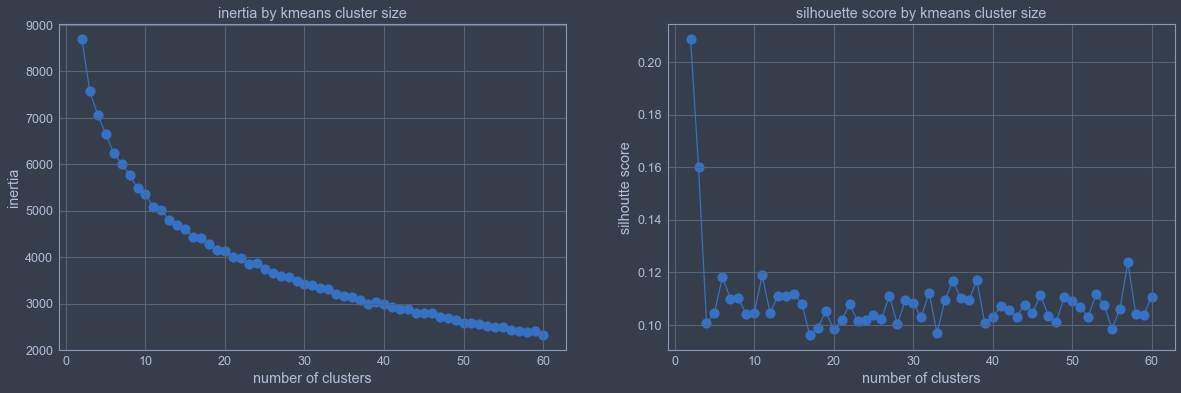

In [47]:
inertias = []
sil_scores = []
max_clusters = 60
for n_clusters in tqdm(range(2, max_clusters+1)):
    
    pipeline = Pipeline(
        steps = [
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters = n_clusters))
        ]
    )

    pipeline.fit(metascripts[features])
    inertias.append(pipeline['cluster'].inertia_)

    
    features_scaled = pipeline['scaler'].transform(metascripts[features])
    features_clusters = pipeline.predict(metascripts[features])
    sil_score = silhouette_score(features_scaled, features_clusters)
    sil_scores.append(sil_score)
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))

ax1.plot(range(2, max_clusters + 1), inertias)
ax1.scatter(range(2, max_clusters + 1), inertias, s = 100)
ax1.set_xlabel("number of clusters")
ax1.set_ylabel("inertia")
ax1.set_title("inertia by kmeans cluster size")

ax2.plot(range(2, max_clusters + 1), sil_scores)
ax2.scatter(range(2, max_clusters + 1), sil_scores, s = 100)
ax2.set_xlabel("number of clusters")
ax2.set_ylabel("silhoutte score")
ax2.set_title("silhouette score by kmeans cluster size");

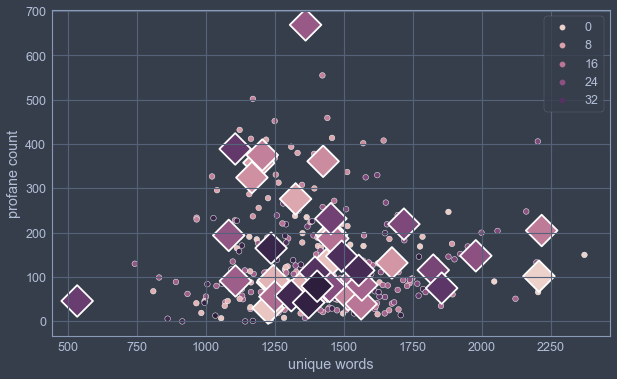

In [57]:
n_clusters = 39
    
pipeline = Pipeline(
    steps = [
        ('scaler', StandardScaler()),
        ('cluster', KMeans(n_clusters = n_clusters))
    ]
)

pipeline.fit(metascripts[features])
inertias.append(pipeline['cluster'].inertia_)


features_scaled = pipeline['scaler'].transform(metascripts[features])
features_clusters = pipeline.predict(metascripts[features])
sil_score = silhouette_score(features_scaled, features_clusters)
sil_scores.append(sil_score)

i = 13
j = 19

plt.figure(figsize = (10,6))
sns.scatterplot(data = metascripts[features],
               x = features[i],
               y = features[j],
               hue = pipeline[1].labels_)

sns.scatterplot(x = pipeline['scaler'].inverse_transform(pipeline['cluster'].cluster_centers_)[:,i],
                y = pipeline['scaler'].inverse_transform(pipeline['cluster'].cluster_centers_)[:,j],
                s = 500, 
                hue = list(range(n_clusters)), 
                marker = 'D',
                legend = False);

## run Louvain algorithm on cosine similarities

In [434]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

In [435]:
graph_df = (widget_df_export.loc[widget_df_export['cosine similarity'] < 0.99999, ['description selection', 'description comparison', 'cosine similarity']]
                            .sort_values(['cosine similarity', 'description comparison'], ascending = False)
                            .drop_duplicates(subset = 'cosine similarity', keep = 'first')
        )

#G = nx.Graph()
G = nx.from_pandas_edgelist(graph_df, 
                        'description selection', 
                        'description comparison', 
                        edge_attr='cosine similarity')

len(G.nodes())

310

In [436]:
graph_df.to_csv('../data/graph_df.csv', index = False) # for Neo4J

note that these weights failed in Python but ran in Neo4J's Louvain algorithm. I'll filter out negative weights below and then check python's Louvain.

## run Louvain without negative weights

In [437]:
graph_df = (widget_df_export.loc[widget_df_export['cosine similarity'].between(0, 0.99999), ['description selection', 'description comparison', 'cosine similarity']]
                            .sort_values(['cosine similarity', 'description comparison'], ascending = False)
                            .drop_duplicates(subset = 'cosine similarity', keep = 'first')
        )

#G = nx.Graph()
G = nx.from_pandas_edgelist(graph_df, 
                        'description selection', 
                        'description comparison', 
                        edge_attr='cosine similarity')

len(G.nodes())

310

In [438]:
communities = community_louvain.best_partition(G, weight = 'cosine similarity')

In [439]:
communities_values = [communities.get(node) for node in tqdm(graph_df['description selection'])]
graph_df['community selection'] = communities_values

  0%|          | 0/30621 [00:00<?, ?it/s]

In [440]:
graph_df['community selection'].value_counts(normalize = True)

1    0.391757
0    0.371575
2    0.236668
Name: community selection, dtype: float64

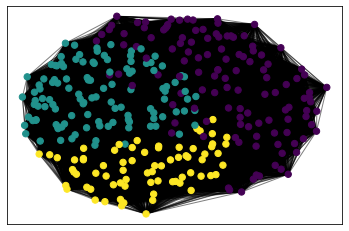

In [441]:
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(communities.values()) + 1)
nx.draw_networkx_nodes(G, pos, communities.keys(), node_size=40,
                       cmap=cmap, node_color=list(communities.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()